In [1]:
import os 
import numpy as np
import healpy as hp
import costi
import matplotlib.pyplot as plt
from costi import (
    Configs,
    get_params,
    component_separation,_get_data_simulations_, _get_noise_simulation, _get_cmb_simulation, _get_data_foregrounds_)
from costi.routines import _EB_to_QU, _get_needlet_windows_
from costi._seds import _get_CMB_SED
%matplotlib inline

In [2]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [4]:
config_path = os.getcwd() + "/configs/config_sosats.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /pscratch/sd/c/carones/SO_extended/configs/config_sosats.yaml


In [5]:
config

Configs(config_path='/pscratch/sd/c/carones/SO_extended/configs/config_sosats.yaml', config={'lmin': 32, 'nside': 128, 'lmax': 256, 'data_type': 'maps', 'fwhm_out': 30.0, 'nsim_start': 0, 'nsims': 1, 'parallelize': False, 'verbose': False, 'foreground_models': ['d1', 's1'], 'experiment': 'SO_SAT', 'bring_to_common_resolution': True, 'input_beams': 'gaussian', 'beams_path': '/pscratch/sd/c/carones/SO_extended/inputs/beams/SO_SAT', 'field_in': 'QU', 'field_out': 'B', 'units': 'uK_CMB', 'generate_input_simulations': True, 'return_fgd_components': False, 'bandpass_integrate': False, 'seed_noise': None, 'seed_cmb': None, 'cls_cmb_path': '/pscratch/sd/c/carones/SO_extended/data/Cls_Planck2018_for_PTEP_2020_r0.fits', 'save_input_simulations': True, 'load_input_simulations': False, 'pixel_window_in': False, 'data_path': '/pscratch/sd/c/carones/SO_extended/inputs/SO_SAT/total/total_maps_ns128_lmin32', 'fgds_path': '/pscratch/sd/c/carones/SO_extended/inputs/SO_SAT/foregrounds/d1s1/foregrounds_ma

In [6]:
foregrounds = _get_data_foregrounds_(config)

In [7]:
data = []
noise = []
cmb = []
for nsim in range(config.nsim_start, config.nsim_start+config.nsims):
    data_, cmb_, noise_ = _get_data_simulations_(config, foregrounds[...,0], nsim=nsim)
    data.append(data_)
    noise.append(noise_)
    cmb.append(cmb_)
data = np.array(data)
noise = np.array(noise)
cmb = np.array(cmb)
data = data[...,None]
noise = noise[...,None]

/pscratch/sd/c/carones/SO_extended/costi/simulations.py:135: RuntimeWarning: divide by zero encountered in power
  N_ell *= (1 + (ell / instrument.ell_knee[nf]) ** instrument.alpha_knee[nf])
/pscratch/sd/c/carones/SO_extended/costi/simulations.py:135: RuntimeWarning: invalid value encountered in multiply
  N_ell *= (1 + (ell / instrument.ell_knee[nf]) ** instrument.alpha_knee[nf])
/pscratch/sd/c/carones/SO_extended/costi/simulations.py:138: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  alm_noise = hp.synalm(N_ell, lmax=3*nside-1, new=True, verbose=False)
/pscratch/sd/c/carones/SO_extended/costi/simulations.py:184: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_alms = hp.synalm(cls_cmb, lmax=lmax, new=new, verbose=False)


In [8]:
data.shape

(1, 6, 3, 196608, 1)

In [9]:
# Compsep runs to be run

config.compsep_runs

[{'method': 'ilc', 'domain': 'pixel', 'ilc_bias': 0.001, 'clusters': None},
 {'method': 'ilc',
  'domain': 'needlet',
  'needlet_config': [{'needlet_windows': 'cosine'},
   {'ell_peaks': [0, 100, 150]}],
  'ilc_bias': 0.001,
  'reduce_bias': False},
 {'method': 'ilc',
  'domain': 'needlet',
  'needlet_config': [{'needlet_windows': 'cosine'},
   {'ell_peaks': [0, 100, 150]}],
  'ilc_bias': 0.0,
  'adapt_nside': False}]

## Importing the SO hits map and creating SO patch

0.3534698486328125


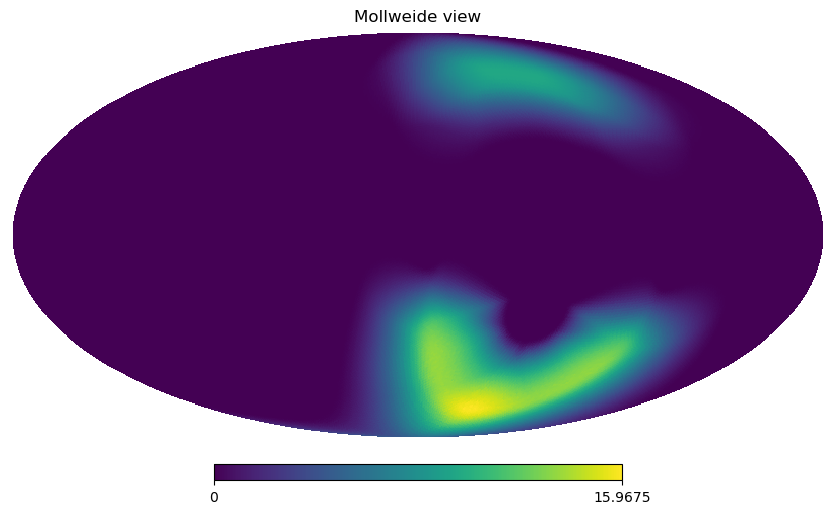

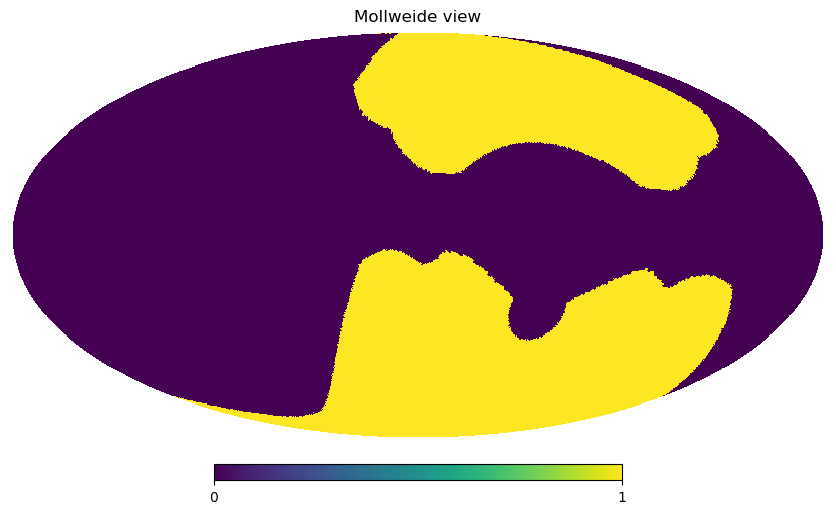

In [10]:
hits_SO = hp.read_map(os.getcwd() + '/data/norm_nHits_SA_35FOV_ns512.fits')
hits_SO = change_coord(hits_SO, ['C','G'])
hits_SO_nside = hp.ud_grade(hits_SO,nside_out=config.nside,power=-2)
hp.mollview(hits_SO_nside)
# hp.get_nside(hits_SO_nside)
mask_SO = np.zeros(12 * config.nside**2)
mask_SO[hits_SO_nside > 0.] = 1.
hp.mollview(mask_SO)
print(mask_SO.mean())

## Run with input B-mode maps reconstructed over the full sky

In [11]:
config.field_in = "QU"
config.field_out = "B"
config.mask_type = "mask_for_compsep" #"observed_patch" #
print(config.leakage_correction)

for idx, nsim in enumerate(range(config.nsim_start, config.nsim_start+config.nsims)):
    combined_data = np.concatenate([data[idx], noise[idx], foregrounds], axis=3)
    component_separation(config, combined_data[:,1:], nsim=nsim, mask=mask_SO)

B_recycling
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.


/pscratch/sd/c/carones/SO_extended/costi/routines.py:462: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  stat_out = hp.alm2map(alm_s, nside_covar, lmax=lmax_stat, verbose=False)
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Realistic run where B-mode input maps are obtained from masked QU maps

In [ ]:
config.field_in = "QU"
config.field_out = "B"
config.mask_type = "observed_patch" #
config.leakage_correction = "B_recycling" #None # "B_recycling_iterations3"

for idx, nsim in enumerate(range(config.nsim_start, config.nsim_start+config.nsims)):
    combined_data = np.concatenate([data[idx], noise[idx], foregrounds], axis=3)
    component_separation(config, combined_data[:,1:], nsim=nsim, mask=mask_SO)